In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from adjustText import adjust_text

from sklearn.linear_model import LinearRegression

### 4.1 Load data

In [2]:
# Import population_per_postal_code data
population_raw_data = pd.read_csv('data/population_per_postal_code.csv')
population_raw_data.head()

,postal_code,estimated_cat_population,estimated_dog_population
0,AB10,"1,675.72","1,921.75"
1,AB11,"2,072.99","2,377.35"
2,AB12,"3,601.57","4,130.35"
3,AB13,"1,153.84","1,323.24"
4,AB14,"2,325.13","2,666.50"


In [3]:
# Display a random sample of 25 rows from the population_raw_data DF
population_raw_data.sample(25, random_state=0)

,postal_code,estimated_cat_population,estimated_dog_population
841,FK8,"4,047.52","4,641.78"
1482,M29,"1,819.85","2,087.04"
1037,HU14,"5,004.44","5,739.20"
1644,NE9,"7,537.37","8,644.01"
1302,L74,0,0
2412,SW1E,207.1125135,237.5209847
1098,IP5,"4,335.76","4,972.34"
1070,IP1,"4,781.31","5,483.31"
491,CV47,"3,723.45","4,270.13"
224,BN2,"14,037.54","16,098.55"


In [4]:
# Import avg_per_household data
avg_raw_data = pd.read_csv('data/avg_per_household.csv')
avg_raw_data.head()

,postcode,cats_per_household,dogs_per_household
0,AB10,0.164463,0.188610
1,AB11,0.206145,0.236411
2,AB12,0.300306,0.344397
3,AB13,1.145815,1.314045
4,AB14,1.008732,1.156835


In [5]:
# Rename 'postcode' to 'postal_code' for ease of merging
avg_raw_data = avg_raw_data.rename(columns={'postcode': 'postal_code'})
avg_raw_data.head()

,postal_code,cats_per_household,dogs_per_household
0,AB10,0.164463,0.188610
1,AB11,0.206145,0.236411
2,AB12,0.300306,0.344397
3,AB13,1.145815,1.314045
4,AB14,1.008732,1.156835


In [6]:
# Import postal_codes_areas data
postcodes_raw_data = pd.read_csv('data/postal_codes_areas.csv')
postcodes_raw_data.head()

,postal_code,town,county,population,num_households,uk_region
0,AB1,Aberdeen,Aberdeen,NaN,NaN,Scotland
1,AB2,Aberdeen,Aberdeen,NaN,NaN,Scotland
2,AB3,Aberdeen,Aberdeen,NaN,NaN,Scotland
3,AB4,"Fraserburgh, Peterhead, Macduff",Aberdeen,NaN,NaN,Scotland
4,AB5,"Buckie, Huntly, Inverurie",Aberdeen,NaN,NaN,Scotland


In [7]:
# Count the NaN
postcodes_raw_data.isna().sum()

postal_code         0
town                0
county              1
population        301
num_households    301
uk_region          36
dtype: int64

In [8]:
# Import ukpostcode data to include long and lat
longlat_raw_data = pd.read_csv('data/ukpostcodes.csv')
longlat_raw_data.head()

,id,postcode,latitude,longitude
0,916411,LE19 0AL,52.583332,-1.209052
1,1844,ZE2 9EQ,60.800694,-0.869518
2,1837,ZE2 9EF,60.799322,-0.813505
3,1711,ZE2 9TP,60.798772,-0.817366
4,1840,ZE2 9EJ,60.798716,-0.815035


In [9]:
# Group the postcodes by their prefixes
grouped = longlat_raw_data.groupby(longlat_raw_data['postcode'].str.extract(r'([A-Z]+\d+)')[0])

# Take the first data point of longitude and latitude for each group, for simplicity
geolocation = grouped.agg({'latitude': 'first',
                           'longitude': 'first'}).reset_index()

# Rename 'postal_code'
geolocation = geolocation.rename(columns={0: 'postal_code'})
geolocation.head()

,postal_code,latitude,longitude
0,AB10,57.144156,-2.114864
1,AB11,57.142701,-2.093295
2,AB12,57.148707,-2.097806
3,AB14,57.101557,-2.268502
4,AB15,57.153997,-2.224402


In [10]:
geolocation.shape

(1895, 3)

In [11]:
longlat_raw_data['postcode'].str.extract(r'(\d[A-Z]+)')

,0
0,0AL
1,9EQ
2,9EF
3,9TP
4,9EJ
...,...
1048570,0NJ
1048571,0NH
1048572,0HE
1048573,0PL


### Merge datasets

In [12]:
# Merge population_raw_data and avg_raw_data, on='postal_code' using a left join
merged_df = pd.merge(population_raw_data, avg_raw_data, on='postal_code', how='left')

# Merge the previously merged DF with postcodes_raw_data on 'postal_code' using left join
merged_df = pd.merge(merged_df, postcodes_raw_data[['postal_code', 'uk_region', 'county', 'town', 'population', 'num_households']],
                     on='postal_code', how='left')
merged_df

,postal_code,estimated_cat_population,estimated_dog_population,cats_per_household,dogs_per_household,uk_region,county,town,population,num_households
0,AB10,"1,675.72","1,921.75",0.164463,0.188610,Scotland,Aberdeen,"Aberdeen city centre, Bridge of Dee, Mannofield",21964.0,11517.0
1,AB11,"2,072.99","2,377.35",0.206145,0.236411,Scotland,Aberdeen,"Aberdeen city centre, Torry",21237.0,10926.0
2,AB12,"3,601.57","4,130.35",0.300306,0.344397,Scotland,Aberdeen,"Aberdeen, Altens, Ardoe, Banchory Devenick, Bl...",25414.0,10688.0
3,AB13,"1,153.84","1,323.24",1.145815,1.314045,Scotland,Aberdeen,Milltimber,2725.0,947.0
4,AB14,"2,325.13","2,666.50",1.008732,1.156835,Scotland,Aberdeen,"Peterculter, Upper Anguston",4881.0,2162.0
...,...,...,...,...,...,...,...,...,...,...
2825,YO8,"5,115.47","5,866.53",0.261034,0.299359,Yorkshire and The Humber,York,"Barlby, Brayton, Bubwith, Cawood, Camblesforth...",43547.0,18145.0
2826,ZE1,"1,895.51","2,173.81",0.454124,0.520799,Scotland,Shetland,"Lerwick, Scalloway",8445.0,3862.0
2827,ZE2,"4,586.34","5,259.71",0.677350,0.776799,Scotland,Shetland,Shetland,14209.0,5845.0
2828,ZE3,105.0080493,120.4254386,0.458550,0.525875,Scotland,Shetland,Bush,432.0,208.0


### 4.3 Data Preprocessing

In [13]:
# Check rows and cols
merged_df.shape

(2830, 10)

In [14]:
# Check data types
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postal_code               2830 non-null   object 
 1   estimated_cat_population  2830 non-null   object 
 2   estimated_dog_population  2830 non-null   object 
 3   cats_per_household        2830 non-null   float64
 4   dogs_per_household        2830 non-null   float64
 5   uk_region                 2830 non-null   object 
 6   county                    2830 non-null   object 
 7   town                      2830 non-null   object 
 8   population                2734 non-null   float64
 9   num_households            2734 non-null   float64
dtypes: float64(4), object(6)
memory usage: 221.2+ KB


In [15]:
# Convert data type
merged_df['estimated_cat_population'] = merged_df['estimated_cat_population'].str.replace(',', '').astype(float)
merged_df['estimated_dog_population'] = merged_df['estimated_dog_population'].str.replace(',', '').astype(float)
merged_df

,postal_code,estimated_cat_population,estimated_dog_population,cats_per_household,dogs_per_household,uk_region,county,town,population,num_households
0,AB10,1675.720000,1921.750000,0.164463,0.188610,Scotland,Aberdeen,"Aberdeen city centre, Bridge of Dee, Mannofield",21964.0,11517.0
1,AB11,2072.990000,2377.350000,0.206145,0.236411,Scotland,Aberdeen,"Aberdeen city centre, Torry",21237.0,10926.0
2,AB12,3601.570000,4130.350000,0.300306,0.344397,Scotland,Aberdeen,"Aberdeen, Altens, Ardoe, Banchory Devenick, Bl...",25414.0,10688.0
3,AB13,1153.840000,1323.240000,1.145815,1.314045,Scotland,Aberdeen,Milltimber,2725.0,947.0
4,AB14,2325.130000,2666.500000,1.008732,1.156835,Scotland,Aberdeen,"Peterculter, Upper Anguston",4881.0,2162.0
...,...,...,...,...,...,...,...,...,...,...
2825,YO8,5115.470000,5866.530000,0.261034,0.299359,Yorkshire and The Humber,York,"Barlby, Brayton, Bubwith, Cawood, Camblesforth...",43547.0,18145.0
2826,ZE1,1895.510000,2173.810000,0.454124,0.520799,Scotland,Shetland,"Lerwick, Scalloway",8445.0,3862.0
2827,ZE2,4586.340000,5259.710000,0.677350,0.776799,Scotland,Shetland,Shetland,14209.0,5845.0
2828,ZE3,105.008049,120.425439,0.458550,0.525875,Scotland,Shetland,Bush,432.0,208.0


In [16]:
merged_df.describe()

,estimated_cat_population,estimated_dog_population,cats_per_household,dogs_per_household,population,num_households
count,2830.000000,2830.000000,2830.000000,2830.000000,2734.000000,2734.000000
mean,3574.121561,4098.877737,0.451960,0.518317,22445.430871,9413.558888
std,3175.924642,3642.217209,0.401342,0.460267,16649.370756,6850.879208
min,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,1223.782500,1403.455000,0.196758,0.225646,9195.750000,3992.750000
50%,2794.390000,3204.665000,0.340893,0.390943,20422.000000,8654.500000
75%,5085.580000,5832.255000,0.592085,0.679015,32520.250000,13602.500000
max,23544.450000,27001.270000,5.212126,5.977375,153812.000000,61886.000000


##### Observation:
Overall, dog ownership in the UK is more prevalent than cat ownership, with an average of 0.52 dogs per household compared to 0.45 cats per household. The average estimated dog population (4098.88) is slightly higher than the average estimated cat population (3574.12).

Addtionally, all minimum values for estimated cat population, estimated dog population, cats per household, and dogs per household are 0. In the following section, we will conduct a detailed analysis to identify and rectify any potential data errors.

Furthermore, we observe that the minimum population is 2, with a correstponding num_household of 1. Upon closer examination of the data, this finding is not surprising, as the location is in Stockley Park, a known non-residential area.

### 4.3.2 Null data

In [17]:
zero_population_rows = merged_df[(merged_df['estimated_cat_population'] == 0) & (merged_df['estimated_dog_population'] == 0)]
zero_population_rows

,postal_code,estimated_cat_population,estimated_dog_population,cats_per_household,dogs_per_household,uk_region,county,town,population,num_households
149,AB99,0.0,0.0,0.0,0.0,Scotland,Aberdeen,Non-geographic,NaN,NaN
150,B99,0.0,0.0,0.0,0.0,West Midlands,Birmingham,Non-geographic,NaN,NaN
291,BB94,0.0,0.0,0.0,0.0,North West,Pendle,"Non-geographic, Earby",NaN,NaN
292,BD97,0.0,0.0,0.0,0.0,Yorkshire and The Humber,Bradford,Bingley,NaN,NaN
293,BD98,0.0,0.0,0.0,0.0,Yorkshire and The Humber,Bradford,Shipley,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2803,WA88,0.0,0.0,0.0,0.0,North West,Halton,"Non-geographic, Widnes",NaN,NaN
2804,WD99,0.0,0.0,0.0,0.0,East of England,Watford,Non-geographic,NaN,NaN
2805,WF90,0.0,0.0,0.0,0.0,Yorkshire and The Humber,Wakefield,Non-geographic,NaN,NaN
2806,WR99,0.0,0.0,0.0,0.0,West Midlands,Worcester,Worcester,NaN,NaN


### Observations:
We can observe from the above pie chart that rows with null values for population and num_households correspond to non-residential areas such as non-geographic locations, banks british gas facilities, post office boxes, and bulk user areas. This is further supported by cross-checking the postal codes, which indicates that majority of the null data points represent non-residential areas. Therefore, I will replace these values with 0.

In [18]:
# Replace null values with 0
merged_df['population'] = merged_df['population'].fillna(0)
merged_df['num_households'] = merged_df['num_households'].fillna(0)

In [19]:
# Check for missing values, if any
merged_df.isna().sum()

postal_code                 0
estimated_cat_population    0
estimated_dog_population    0
cats_per_household          0
dogs_per_household          0
uk_region                   0
county                      0
town                        0
population                  0
num_households              0
dtype: int64

### 4.3.3 Possible erroneous data

In [20]:
# View possible erroneous data
merged_df[(merged_df['postal_code'] == 'W1A') | (merged_df['postal_code'] == 'EC2P')]

,postal_code,estimated_cat_population,estimated_dog_population,cats_per_household,dogs_per_household,uk_region,county,town,population,num_households
688,EC2P,0.567535,0.650861,0.567535,0.650861,London,London,Non-geographic,0.0,0.0
2651,W1A,1.227162,1.407335,1.227162,1.407335,London,Westminster,Non-geographic,0.0,0.0


In [21]:
merged_df.head()

,postal_code,estimated_cat_population,estimated_dog_population,cats_per_household,dogs_per_household,uk_region,county,town,population,num_households
0,AB10,1675.72,1921.75,0.164463,0.188610,Scotland,Aberdeen,"Aberdeen city centre, Bridge of Dee, Mannofield",21964.0,11517.0
1,AB11,2072.99,2377.35,0.206145,0.236411,Scotland,Aberdeen,"Aberdeen city centre, Torry",21237.0,10926.0
2,AB12,3601.57,4130.35,0.300306,0.344397,Scotland,Aberdeen,"Aberdeen, Altens, Ardoe, Banchory Devenick, Bl...",25414.0,10688.0
3,AB13,1153.84,1323.24,1.145815,1.314045,Scotland,Aberdeen,Milltimber,2725.0,947.0
4,AB14,2325.13,2666.50,1.008732,1.156835,Scotland,Aberdeen,"Peterculter, Upper Anguston",4881.0,2162.0


## 5. EDA

### 5.1 Phân tích đơn biến

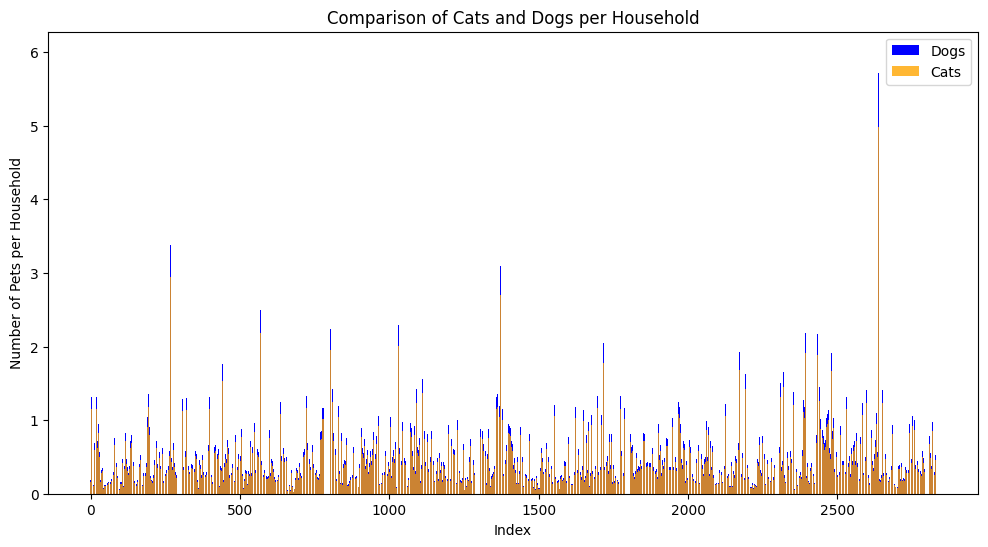

In [22]:
# Create a bar chart showing all data points for cats and dogs
plt.figure(figsize=(12,6))
plt.bar(merged_df.index, merged_df['dogs_per_household'], color='blue', label='Dogs')
plt.bar(merged_df.index, merged_df['cats_per_household'], color='orange', label='Cats', alpha=0.8)

plt.xlabel('Index')
plt.ylabel('Number of Pets per Household')
plt.title('Comparison of Cats and Dogs per Household')
plt.legend()
plt.show()

#### Obeservation:
The bar chart illustrates a consistent trend across all data points: households tend to own more dogs than cats. This preference for dogs over cats in terms of ownership suggests a significant cultural or practical inclination towards canine companionship among pet owners.

### 5.2 Pet per household by region

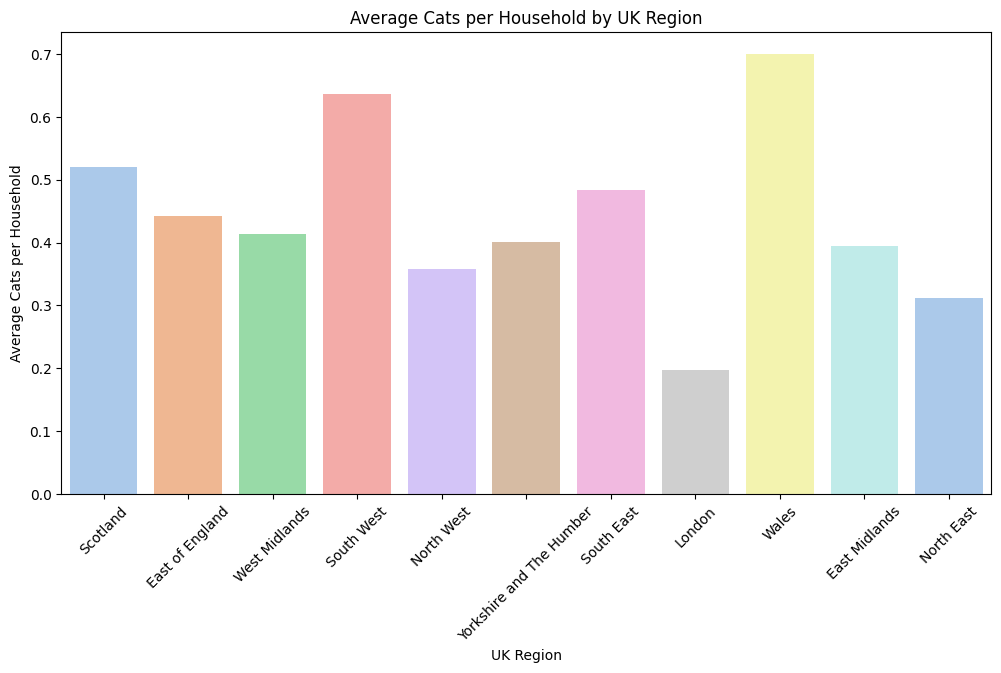

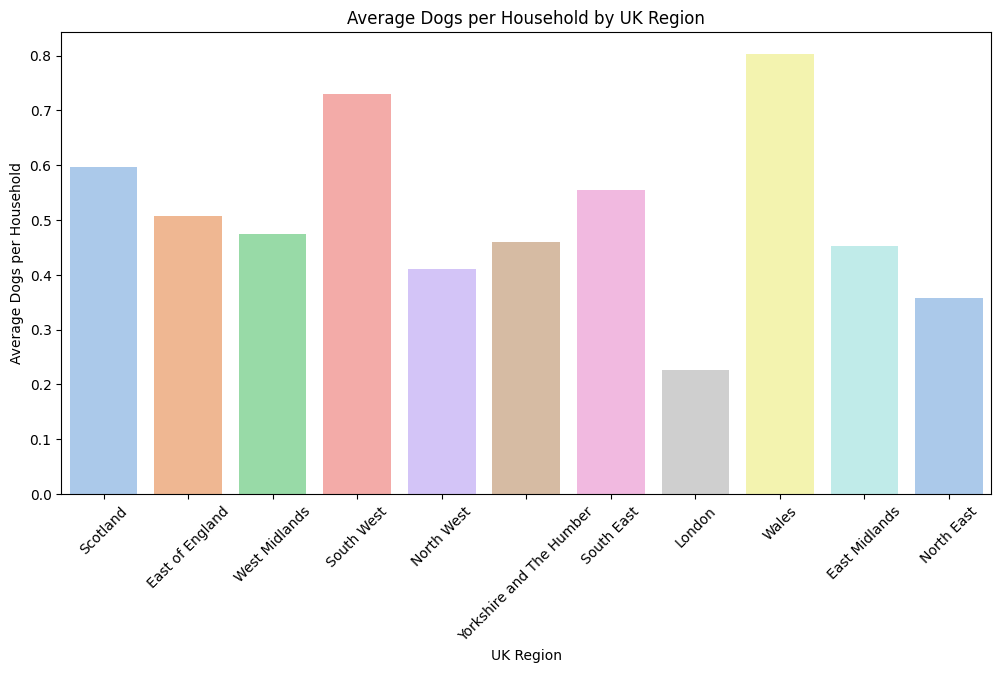

In [23]:
def plot_avg_pet_per_household(df, pet_type):
    """
    Plot the average number of a specific type of pet per household by UK region.

    Parameter:
    - df (DataFrame): The DataFrame containing the data.
    - pet_type (str): The type of pet ('cats' or 'dogs') to plot.

    Returns:
    - None
    """
    column_name = f'{pet_type}_per_household'

    # Bar plot of average pets per household by UK region
    colors = sns.color_palette("pastel")
    plt.figure(figsize=(12,6))
    sns.barplot(data=df, x='uk_region', y=column_name, errorbar=None, palette=colors)
    plt.title(f'Average {pet_type.capitalize()} per Household by UK Region')
    plt.xlabel('UK Region')
    plt.ylabel(f'Average {pet_type.capitalize()} per Household')
    plt.xticks(rotation=45)
    plt.show()

plot_avg_pet_per_household(merged_df, 'cats')
plot_avg_pet_per_household(merged_df, 'dogs')

#### Observations:
The highest number of cats/dogs per household is found in Wales, South West, and Scotland, while lowest number is in London. Across all regions, the average number of dogs per household is higher than that of cats. This suggests that dog ownership is generally more prevalent than cat ownership.

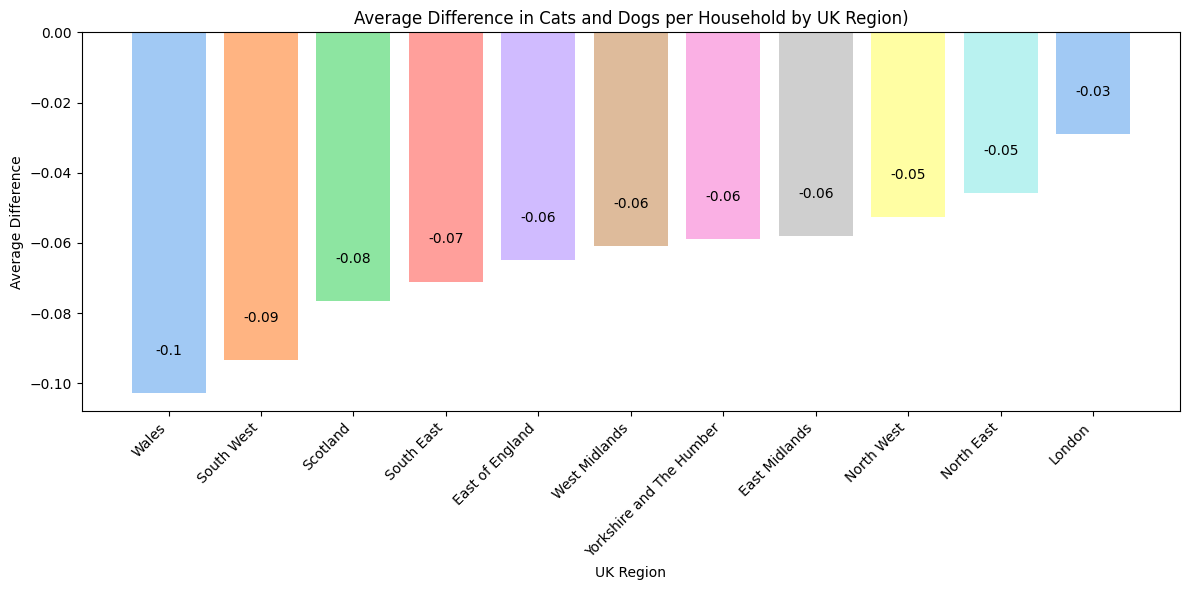

In [24]:
# Calculate the difference between cats_per_household and dogs_per_househld
merged_df['diff_cats_dogs'] = merged_df['cats_per_household'] - merged_df['dogs_per_household']

# Group by uk_region and calculate the average difference
avg_diff_by_region = merged_df.groupby('uk_region')['diff_cats_dogs'].mean().reset_index()

# Sort the DataFramme by the 'diff_cats_dogs' column
avg_diff_by_region = avg_diff_by_region.sort_values(by='diff_cats_dogs')

plt.figure(figsize=(12, 6))
bars = plt.bar(avg_diff_by_region['uk_region'], avg_diff_by_region['diff_cats_dogs'], color=sns.color_palette("pastel"))

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.xlabel('UK Region')
plt.ylabel('Average Difference')
plt.title('Average Difference in Cats and Dogs per Household by UK Region)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Observations:
The London region has the smallest difference between the average number of cats and dogs per household compared to other UK regions

### 5.3 Pet per household by region (Lon & Lat)

In [25]:
# Merge the DataFrame with geolocation data based on postal code
merged_df_geolocation = pd.merge(merged_df, geolocation[['postal_code', 'latitude', 'longitude']], on='postal_code', how='left')
merged_df_geolocation

,postal_code,estimated_cat_population,estimated_dog_population,cats_per_household,dogs_per_household,uk_region,county,town,population,num_households,diff_cats_dogs,latitude,longitude
0,AB10,1675.720000,1921.750000,0.164463,0.188610,Scotland,Aberdeen,"Aberdeen city centre, Bridge of Dee, Mannofield",21964.0,11517.0,-0.024147,57.144156,-2.114864
1,AB11,2072.990000,2377.350000,0.206145,0.236411,Scotland,Aberdeen,"Aberdeen city centre, Torry",21237.0,10926.0,-0.030266,57.142701,-2.093295
2,AB12,3601.570000,4130.350000,0.300306,0.344397,Scotland,Aberdeen,"Aberdeen, Altens, Ardoe, Banchory Devenick, Bl...",25414.0,10688.0,-0.044091,57.148707,-2.097806
3,AB13,1153.840000,1323.240000,1.145815,1.314045,Scotland,Aberdeen,Milltimber,2725.0,947.0,-0.168230,NaN,NaN
4,AB14,2325.130000,2666.500000,1.008732,1.156835,Scotland,Aberdeen,"Peterculter, Upper Anguston",4881.0,2162.0,-0.148103,57.101557,-2.268502
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,YO8,5115.470000,5866.530000,0.261034,0.299359,Yorkshire and The Humber,York,"Barlby, Brayton, Bubwith, Cawood, Camblesforth...",43547.0,18145.0,-0.038325,53.852073,-0.995869
2826,ZE1,1895.510000,2173.810000,0.454124,0.520799,Scotland,Shetland,"Lerwick, Scalloway",8445.0,3862.0,-0.066675,60.187721,-1.152920
2827,ZE2,4586.340000,5259.710000,0.677350,0.776799,Scotland,Shetland,Shetland,14209.0,5845.0,-0.099449,60.800694,-0.869518
2828,ZE3,105.008049,120.425439,0.458550,0.525875,Scotland,Shetland,Bush,432.0,208.0,-0.067325,59.892392,-1.310899


In [26]:
# Check for null rows in the merged dataset
missing_location_data = merged_df_geolocation[(merged_df_geolocation['latitude'].isnull()) | (merged_df_geolocation['longitude'].isnull())]
missing_location_data

,postal_code,estimated_cat_population,estimated_dog_population,cats_per_household,dogs_per_household,uk_region,county,town,population,num_households,diff_cats_dogs,latitude,longitude
3,AB13,1153.840000,1323.240000,1.145815,1.314045,Scotland,Aberdeen,Milltimber,2725.0,947.0,-0.168230,NaN,NaN
8,AB22,1950.470000,2236.840000,0.271464,0.311321,Scotland,Aberdeen,"Aberdeen, Bridge of Don, Danestone, Grandholm,...",16311.0,6978.0,-0.039857,NaN,NaN
11,AB25,851.003551,975.948764,0.103617,0.118830,Scotland,Aberdeen,"Aberdeen city centre, Kittybrewster, Foresterh...",18407.0,9634.0,-0.015213,NaN,NaN
12,AB30,4225.420000,4845.810000,1.330842,1.526238,Scotland,Aberdeenshire,Laurencekirk,7229.0,2935.0,-0.195396,NaN,NaN
13,AB31,3961.300000,4542.910000,0.600470,0.688632,Scotland,Aberdeenshire,Banchory,15319.0,6096.0,-0.088162,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698,WC2E,42.041480,48.214054,0.072862,0.083560,London,Westminster,Covent Garden,647.0,392.0,-0.010698,NaN,NaN
2699,WC2H,79.051578,90.658011,0.046776,0.053644,London,Westminster,Leicester Square,2932.0,1485.0,-0.006868,NaN,NaN
2700,WC2N,54.109403,62.053801,0.134936,0.154748,London,Westminster,Charing Cross,861.0,376.0,-0.019811,NaN,NaN
2701,WC2R,12.465760,14.295995,0.082555,0.094675,London,Westminster,Somerset House,138.0,53.0,-0.012121,NaN,NaN


In [27]:
# Fill NaN values in 'longitude' and 'latitude' columns with the average values
# grouped by 'uk_region' and 'county'. Then round 'longitude' and 'latitude'
# columns to 6 decimal places.
merged_df_geolocation['longitude'] = (merged_df_geolocation['longitude']
                                      .fillna(merged_df_geolocation
                                              .groupby(['uk_region', 'county'])['longitude']
                                              .transform('mean')))
merged_df_geolocation['latitude'] = (merged_df_geolocation['latitude']
                                      .fillna(merged_df_geolocation
                                              .groupby(['uk_region', 'county'])['latitude']
                                              .transform('mean')))

merged_df_geolocation['longitude'] = merged_df_geolocation['longitude'].round(6)
merged_df_geolocation['latitude'] = merged_df_geolocation['latitude'].round(6)

merged_df_geolocation

,postal_code,estimated_cat_population,estimated_dog_population,cats_per_household,dogs_per_household,uk_region,county,town,population,num_households,diff_cats_dogs,latitude,longitude
0,AB10,1675.720000,1921.750000,0.164463,0.188610,Scotland,Aberdeen,"Aberdeen city centre, Bridge of Dee, Mannofield",21964.0,11517.0,-0.024147,57.144156,-2.114864
1,AB11,2072.990000,2377.350000,0.206145,0.236411,Scotland,Aberdeen,"Aberdeen city centre, Torry",21237.0,10926.0,-0.030266,57.142701,-2.093295
2,AB12,3601.570000,4130.350000,0.300306,0.344397,Scotland,Aberdeen,"Aberdeen, Altens, Ardoe, Banchory Devenick, Bl...",25414.0,10688.0,-0.044091,57.148707,-2.097806
3,AB13,1153.840000,1323.240000,1.145815,1.314045,Scotland,Aberdeen,Milltimber,2725.0,947.0,-0.168230,57.181293,-2.150121
4,AB14,2325.130000,2666.500000,1.008732,1.156835,Scotland,Aberdeen,"Peterculter, Upper Anguston",4881.0,2162.0,-0.148103,57.101557,-2.268502
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,YO8,5115.470000,5866.530000,0.261034,0.299359,Yorkshire and The Humber,York,"Barlby, Brayton, Bubwith, Cawood, Camblesforth...",43547.0,18145.0,-0.038325,53.852073,-0.995869
2826,ZE1,1895.510000,2173.810000,0.454124,0.520799,Scotland,Shetland,"Lerwick, Scalloway",8445.0,3862.0,-0.066675,60.187721,-1.152920
2827,ZE2,4586.340000,5259.710000,0.677350,0.776799,Scotland,Shetland,Shetland,14209.0,5845.0,-0.099449,60.800694,-0.869518
2828,ZE3,105.008049,120.425439,0.458550,0.525875,Scotland,Shetland,Bush,432.0,208.0,-0.067325,59.892392,-1.310899


In [28]:
# Fill remaining NaN values in 'longitude' and 'latitude' columns with the average values
# grouped by 'uk_region' only, as the there is no data for 'longitude' and 'latitude' for the county with missing values
merged_df_geolocation['longitude'] = (merged_df_geolocation['longitude']
                                      .fillna(merged_df_geolocation
                                              .groupby(['uk_region'])['longitude']
                                              .transform('mean')))
merged_df_geolocation['latitude'] = (merged_df_geolocation['latitude']
                                      .fillna(merged_df_geolocation
                                              .groupby(['uk_region'])['latitude']
                                              .transform('mean')))
merged_df_geolocation

,postal_code,estimated_cat_population,estimated_dog_population,cats_per_household,dogs_per_household,uk_region,county,town,population,num_households,diff_cats_dogs,latitude,longitude
0,AB10,1675.720000,1921.750000,0.164463,0.188610,Scotland,Aberdeen,"Aberdeen city centre, Bridge of Dee, Mannofield",21964.0,11517.0,-0.024147,57.144156,-2.114864
1,AB11,2072.990000,2377.350000,0.206145,0.236411,Scotland,Aberdeen,"Aberdeen city centre, Torry",21237.0,10926.0,-0.030266,57.142701,-2.093295
2,AB12,3601.570000,4130.350000,0.300306,0.344397,Scotland,Aberdeen,"Aberdeen, Altens, Ardoe, Banchory Devenick, Bl...",25414.0,10688.0,-0.044091,57.148707,-2.097806
3,AB13,1153.840000,1323.240000,1.145815,1.314045,Scotland,Aberdeen,Milltimber,2725.0,947.0,-0.168230,57.181293,-2.150121
4,AB14,2325.130000,2666.500000,1.008732,1.156835,Scotland,Aberdeen,"Peterculter, Upper Anguston",4881.0,2162.0,-0.148103,57.101557,-2.268502
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,YO8,5115.470000,5866.530000,0.261034,0.299359,Yorkshire and The Humber,York,"Barlby, Brayton, Bubwith, Cawood, Camblesforth...",43547.0,18145.0,-0.038325,53.852073,-0.995869
2826,ZE1,1895.510000,2173.810000,0.454124,0.520799,Scotland,Shetland,"Lerwick, Scalloway",8445.0,3862.0,-0.066675,60.187721,-1.152920
2827,ZE2,4586.340000,5259.710000,0.677350,0.776799,Scotland,Shetland,Shetland,14209.0,5845.0,-0.099449,60.800694,-0.869518
2828,ZE3,105.008049,120.425439,0.458550,0.525875,Scotland,Shetland,Bush,432.0,208.0,-0.067325,59.892392,-1.310899


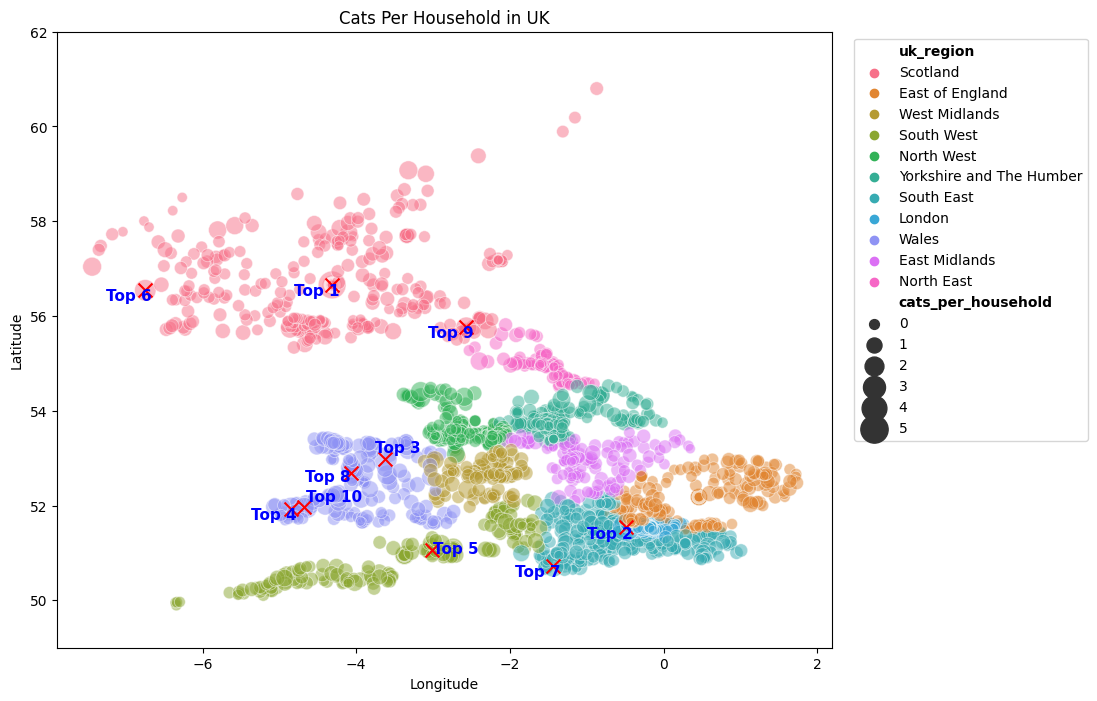

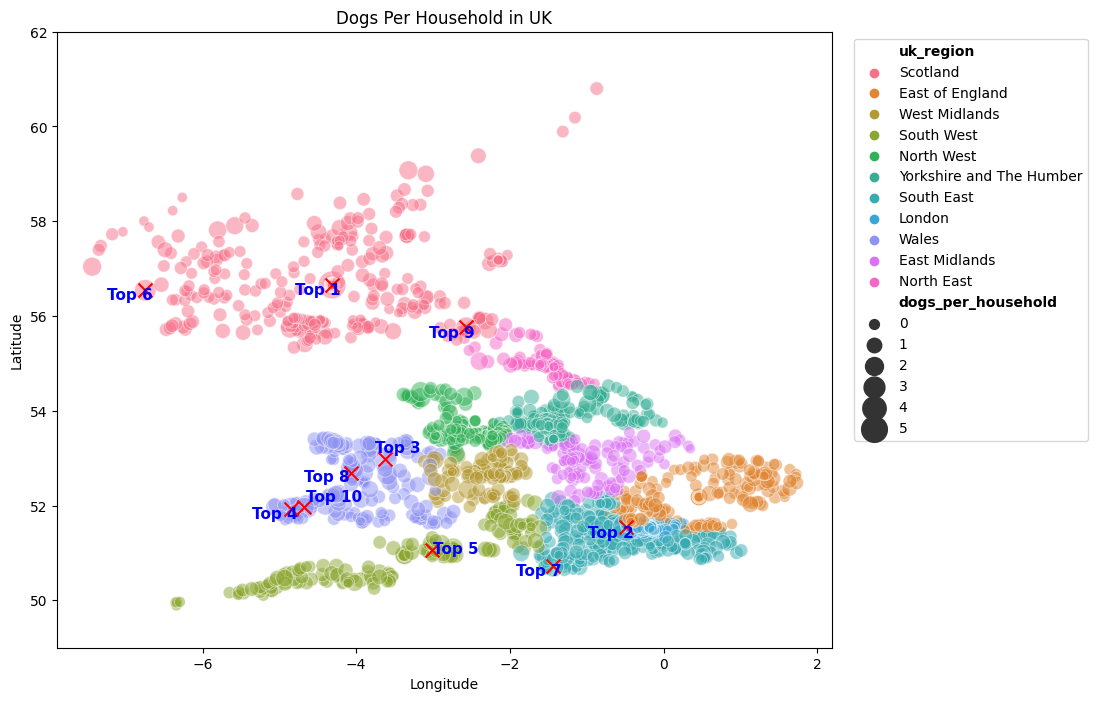

In [29]:
def  plot_pet_ownership_by_coordinates(dataframe, pet_type):
    """
    Plot a scatter plot showing the geographic distribution of pet ownership in the UK.

    Args:
    - dataframe (DataFrame): The input DataFrame containing the data.
    - pet_type (str): The type of pet ('cats' or 'dogs') for which ownership per household is plotted.

    Return:
    - None
    """
    # Define a custom color palette
    custom_palette = sns.color_palette("husl", len(dataframe['uk_region'].unique()))

    # Plot scatter plot
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(x='longitude', y='latitude', hue='uk_region', data=dataframe, palette=custom_palette,
                                size=f'{pet_type}_per_household', sizes=(50, 400), alpha=0.5)

    top_points = dataframe.nlargest(10, f'{pet_type}_per_household')

    # Label the top 10 datapoints
    texts = []
    for i, (index, row) in enumerate(top_points.iterrows()):
        texts.append(plt.text(row['longitude'], row['latitude']+0.05, f'Top {i+1}',
                              color='blue', fontsize=11, ha='center',
                              va='center', weight='bold'))
        plt.scatter(row['longitude'], row['latitude'], color='red',
                    marker='x', s=100)

    # Adjust text in plot
    adjust_text(texts, arrowprops=None)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{pet_type.title()} Per Household in UK')
    plt.ylim(49, 62)

    # Adjust legend
    legend = scatter.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    for label in legend.get_texts():
        if label.get_text() in ['uk_region', f'{pet_type}_per_household']:
            label.set_fontweight('bold')

    plt.show()

plot_pet_ownership_by_coordinates(merged_df_geolocation, 'cats')
plot_pet_ownership_by_coordinates(merged_df_geolocation, 'dogs')

### 5.4 Pet per household by county

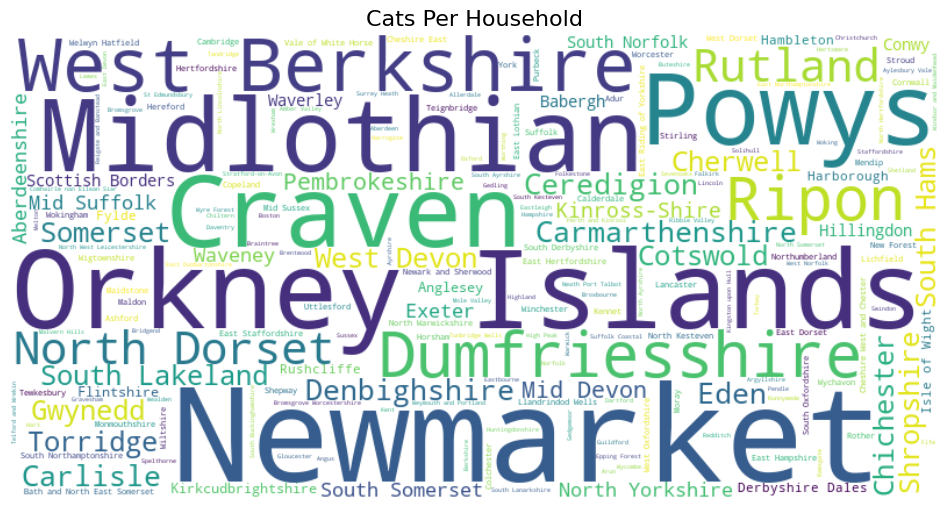

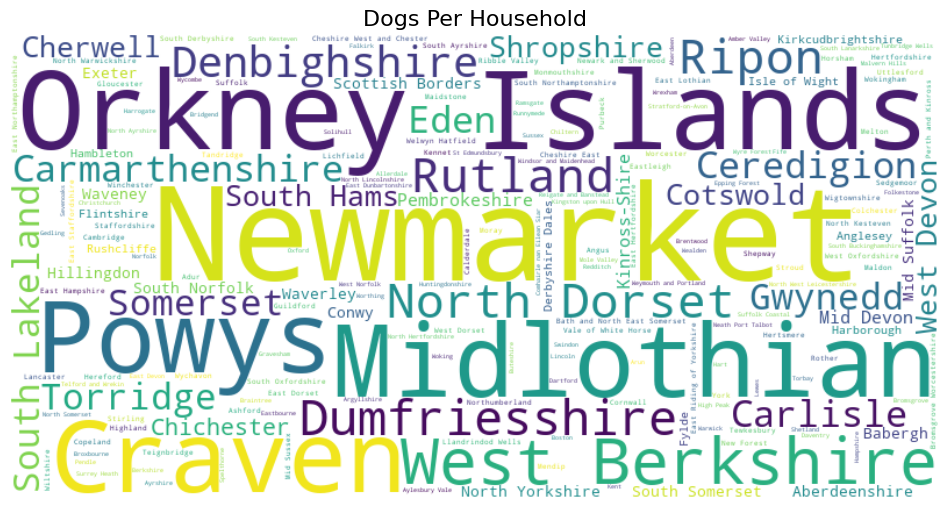

In [30]:
def plot_per_ownership_wordcloud(df, pet_type):
    """
    Generate a word cloud showing the average pet ownership per household by county.

    Args:
    - df (DataFrame): The input DataFrame cointaining the data.
    - pet_type (str): The type of pet ('cats' or 'dogs') for which ownership per house
    is plotted.

    Return:
    - None
    """
    column_name = f'{pet_type}_per_household'
    avg_ownership = df.groupby('county')[column_name].mean().reset_index()

    # Create a dictionary with county names as keys and avg ownership as values
    county_ownership_dict = avg_ownership.set_index('county')[column_name].to_dict()

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white')\
                .generate_from_frequencies(county_ownership_dict)
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{pet_type.capitalize()} Per Household', fontsize=16)
    plt.show()

plot_per_ownership_wordcloud(merged_df, 'cats')
plot_per_ownership_wordcloud(merged_df, 'dogs')

#### Observation:
The top ten counties with the highest average pet population show a consistent trend for both cats and dogs. These counties, in descending order, are Newmarket...

### 5.5 Pet per household by town

In [31]:
def print_top_pet_counties(df, pet_type):
    """
    Print the top 20 counties with the highest population of a specific pet type per
    household.

    Args:
    - df (DataFrame): The input DataFrame containing the data.
    - pet_type (str): 'cat' or 'dog'

    Returns:
    - None
    """
    column_name = f'{pet_type}s_per_household'
    top_counties = df.sort_values(by=column_name, ascending=False).head(20)

    print(f"Top 20 towns with highest {pet_type} per household:")
    for index, row in top_counties.iterrows():
        print(f"{row['town']}: {round(row[column_name], 2)}")
    print()

print_top_pet_counties(merged_df, 'cat')
print_top_pet_counties(merged_df, 'dog')

Top 20 towns with highest cat per household:
Roslin, Bilston: 5.21
Stockley Park: 4.98
Bala, Llandderfel, Llanfor, Llanuwchllyn, Sarnau: 3.87
Clarbeston Road: 3.64
Wedmore: 2.94
Isle Of Tiree: 2.81
Yarmouth: 2.79
Llwyngwril: 2.7
Gordon: 2.56
Clynderwen: 2.36
Llanbrynmair: 2.34
Kirkby-in-Furness: 2.3
Whitland: 2.3
Broughton-in-furness: 2.29
Castle Cary: 2.27
Thornhill: 2.18
Sanquhar: 2.14
Chew Valley, Chew Magna, Chew Stoke, Wrington: 2.12
Tenbury Wells: 2.08
Arkholme, Cantsfield, Casterton, Ingleton, Ireby, Kirkby Lonsdale, Masongill, Tunstall, Whittington: 2.01

Top 20 towns with highest dog per household:
Roslin, Bilston: 5.98
Stockley Park: 5.71
Bala, Llandderfel, Llanfor, Llanuwchllyn, Sarnau: 4.44
Clarbeston Road: 4.17
Wedmore: 3.37
Isle Of Tiree: 3.22
Yarmouth: 3.2
Llwyngwril: 3.1
Gordon: 2.94
Clynderwen: 2.7
Llanbrynmair: 2.68
Kirkby-in-Furness: 2.64
Whitland: 2.64
Broughton-in-furness: 2.63
Castle Cary: 2.6
Thornhill: 2.5
Sanquhar: 2.46
Chew Valley, Chew Magna, Chew Stoke, Wrin

#### Observation:
Most of the towns in the top 20 list have rural settings, offering ample space for pets to roam. Towns like Bala... also provide high access to green spaces, including parks, fields, and countryside, which offer ideal settings for walking dogs and engaging in outdoor activities with pets.

### 5.6 Pet per household vs Estimated pet population

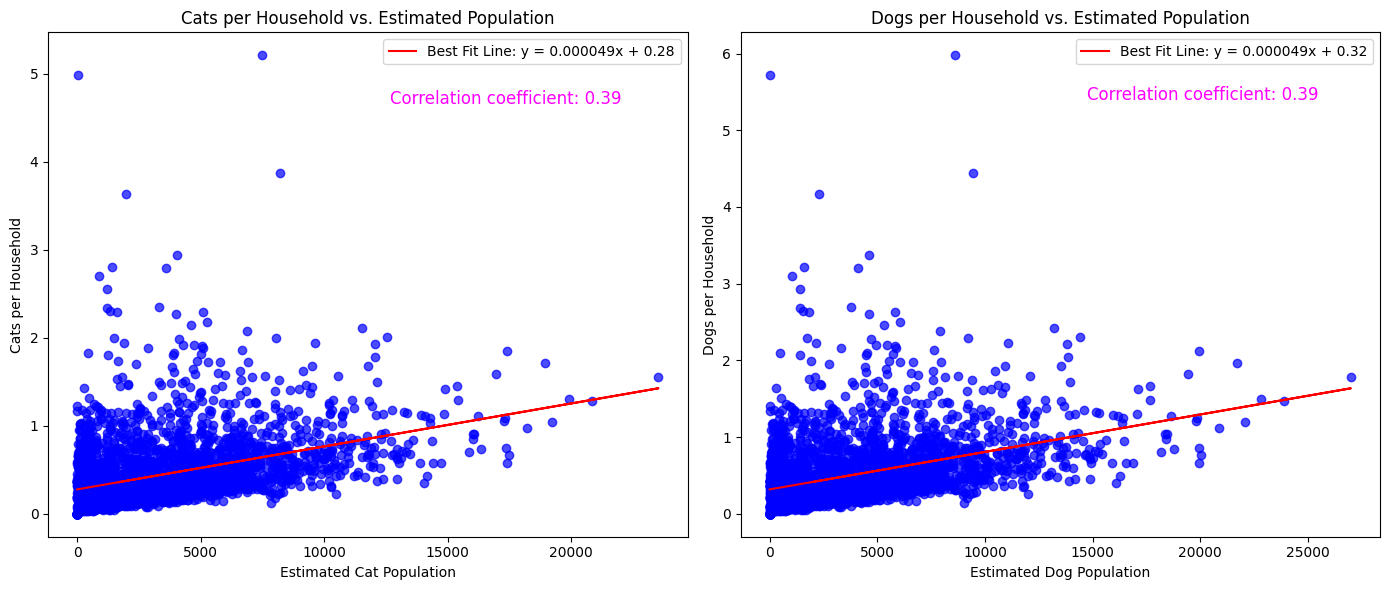

In [37]:
def plot_pets_per_household_vs_est_pet_population(df, pet_types):
    """
    Plot scatter plots with best-fit lines showing the relationship between the number
    and the estimated pet population for each specified pet type.

    Args:
    - df (DataFrame): The input DataFrame containing the data.
    - pet_types (list of str): A list of pet types ('cat' or 'dog')

    Returns:
    - None
    """
    fig, axes = plt.subplots(1, len(pet_types), figsize=(14, 6))

    for i, pet_type in enumerate(pet_types):
        x_column = f'estimated_{pet_type}_population'
        y_column = f'{pet_type}s_per_household'

        # Fit a linear regression model
        X = df[x_column].values.reshape(-1, 1)
        y = df[y_column].values
        model = LinearRegression().fit(X, y)

        # Get the slope (m) and y-intercept (b) of the line
        m, b = model.coef_[0], model.intercept_

        # Calculate the Pearson correlation coefficient
        r = np.corrcoef(df[x_column], df[y_column])[0, 1]

        # Create the line equation and correlation coefficient
        line_eq = f'y = {m:.6f}x + {b:.2f}'
        corr_text = f'Correlation coefficient: {r:.2f}'

        # Create scatter plot
        ax = axes[i]
        ax.scatter(df[x_column], df[y_column], color='b', alpha=0.7)
        ax.plot(df[x_column], model.predict(X), color='r',
                label=f'Best Fit Line: {line_eq}')
        ax.text(df[x_column].max()-1500, df[y_column].max()-0.4, corr_text,
        ha='right', va='top', color='magenta', fontsize=12)

        ax.set_title(f'{pet_type.title()}s per Household vs. Estimated Population')
        ax.set_xlabel(f'Estimated {pet_type.title()} Population')
        ax.set_ylabel(f'{pet_type.title()}s per Household')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_pets_per_household_vs_est_pet_population(merged_df, ['cat', 'dog'])

In [60]:
from scipy.stats import linregress
pet_types = ['cat', 'dog']
for i, pet_type in enumerate(pet_types):
    x_column = f'estimated_{pet_type}_population'
    y_column = f'{pet_type}s_per_household'

    # Fit a linear regression model
    X = merged_df[x_column].values
    y = merged_df[y_column].values
    model_sm = linregress(X, y)
    # Get the p-values for the coefficients
    p_values = model_sm.pvalue
    print(f"P-values for the coefficients {pet_type}: {p_values: }")

P-values for the coefficients cat:  2.2692783528540434e-101
P-values for the coefficients dog:  2.2691859831918082e-101


#### Observation:
The correlation coefficient for both cats and dogs per household compared to their estimated population is 0.39, suggesting a weak positive linear relationship.